In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import xgboost
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE

Using TensorFlow backend.
/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [3]:
df=pd.read_csv('./fdf.csv')
df = df.drop(df.columns[0], axis=1)

In [5]:
df=df.fillna(-1)

In [85]:
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')
# df.sort_values('nDate')
# df.head()

In [86]:
def build_model(lr=0.1,depth=5,estimators=10):
    clf=xgboost.XGBClassifier(learning_rate = lr,max_depth = depth,early_stopping_rounds=10,n_estimators = estimators)
    return clf

In [80]:
# TimeSeries Split
train=df[df["nDate"]<'2019-09-15']
Y_train=train["clicks_level"]
X_train=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

test=df[df["nDate"]>='2019-09-15']
Y_test=test["clicks_level"]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)


# Cross Validation
ac=make_scorer(f1_score,average='macro')
model = build_model(lr=0.1,depth=10,estimators=100)
tscv = TimeSeriesSplit(n_splits=3)
scores = cross_val_score(model, X_train, Y_train, cv=tscv, scoring=ac)
print("Accuracy: {0:.5f} (+/- {1:.5f})".format(scores.mean(), scores.std()))

Accuracy: 0.45752 (+/- 0.00103)


In [ ]:
# GridSearchCV

# Number of Estimators
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]


n_estimators=[5,15]
max_depth=[3,5,8]
learning_rate=[0.05,0.1,0.3]

params = {
    'n_estimators':n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'objective': ('reg:linear','multi:softmax','multi:softprob'),
    'scale_pos_weight' : (1,5),
    'min_child_weight' : (1,5),
    'colsample_bytree' : [0.8]
}

ac=make_scorer(f1_score,greater_is_better=True,average='macro')



model = build_model()
finder = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring=ac,
    fit_params=None,
    n_jobs=None,
    iid=False,
    refit=False,
    cv=tscv,  # change this to the splitter subject to test
    verbose=10,
    pre_dispatch=8,
    error_score=-999
)
finder.fit(X_train, Y_train)
best_params = finder.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.0s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.4s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.4s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.8s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.8s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.5s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.7s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   47.0s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.7s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   51.3s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.4s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   59.2s remaining:    0.0s
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.7s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.3s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softmax, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.8s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.4s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.9s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4335733686155981, total=   4.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4204416254561323, total=   7.3s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=multi:softprob, learning_rate=0.05, n_estimators=5, colsample_bytree=0.8, score=0.4265808617694742, total=  10.8s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8, score=0.432223372695031, total=   9.6s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8, score=0.4297475962021056, total=  18.6s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=1, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8, score=0.41459791047948724, total=  26.8s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 
[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8, score=0.432223372695031, total=   9.5s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8, score=0.4297475962021056, total=  18.1s
[CV] max_depth=3, min_child_weight=1, scale_pos_weight=5, objective=reg:linear, learning_rate=0.05, n_estimators=15, colsample_bytree=0.8 


In [98]:
train=df[df["nDate"]<'2019-09-15']
Y_train=train["clicks_level"].values
X_train=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1).values

In [99]:
X_train.shape,Y_train.shape

((872663, 60), (872663,))

In [100]:
test=df[df["nDate"]>='2019-09-15']
Y_test=test["clicks_level"].values
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1).values

In [101]:
X_test.shape,Y_test.shape

((102039, 60), (102039,))

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(verbose=1,max_depth=5,n_estimators=200,bootstrap=True,max_features='auto')
clf.fit(X_train,Y_train)
ypred=clf.predict(X_test)
print (sklearn.metrics.f1_score(Y_test,ypred,average='macro'))
print (sklearn.metrics.accuracy_score(Y_test,ypred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3623660747533575
0.9850939346720372


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
eset = [(X_train, Y_train), (X_test, Y_test)]
clf=xgboost.XGBClassifier(learning_rate = 0.1,max_depth = 8,early_stopping_rounds=10,n_estimators = 100,eval_metric=["merror"], eval_set=eset,verbose_eval=True)
clf.fit(X_train,Y_train,eval_set=eset,verbose=True)

[0]	validation_0-merror:0.007348	validation_1-merror:0.015484
[1]	validation_0-merror:0.007264	validation_1-merror:0.015621
[2]	validation_0-merror:0.007231	validation_1-merror:0.015425
[3]	validation_0-merror:0.007178	validation_1-merror:0.015376
[4]	validation_0-merror:0.007168	validation_1-merror:0.015318
[5]	validation_0-merror:0.007169	validation_1-merror:0.01518
[6]	validation_0-merror:0.00714	validation_1-merror:0.015112
[7]	validation_0-merror:0.007109	validation_1-merror:0.015102
[8]	validation_0-merror:0.00711	validation_1-merror:0.015014
[9]	validation_0-merror:0.007085	validation_1-merror:0.015043
[10]	validation_0-merror:0.007075	validation_1-merror:0.015112
[11]	validation_0-merror:0.007047	validation_1-merror:0.015082
[12]	validation_0-merror:0.007037	validation_1-merror:0.015043
[13]	validation_0-merror:0.007036	validation_1-merror:0.015024
[14]	validation_0-merror:0.007008	validation_1-merror:0.014955
[15]	validation_0-merror:0.007008	validation_1-merror:0.014916
[16]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10,
       eval_metric=['merror'],
       eval_set=[(array([[ 0.     ,  0.     , ..., 38.42493, 33.99073],
       [ 0.     ,  0.     , ..., 38.42493, 33.99073],
       ...,
       [ 0.     ,  0.     , ..., 23.0271 , 28.5745 ],
       [ 0.     ,  0.     , ..., 23.0271 , 28.5745 ]]), array([0, 0, ..., 0, 0])), (array([[ 0.     ,  0.     , ......98372, 26.97802],
       [ 0.     ,  0.     , ..., 25.98372, 26.97802]]), array([0, 0, ..., 0, 0]))],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose_eval=True)

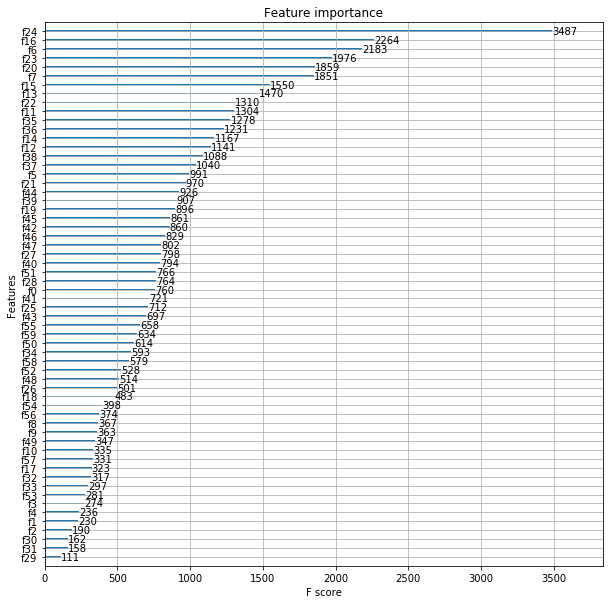

In [62]:
fig,ax=plt.subplots(figsize=(10,10))
xgboost.plot_importance(clf,ax=ax)
# clf.feature_importances_
# df.drop(['nDate','query','date','clicks_level'],axis=1)

In [53]:
np.unique(Y_train)

array([0, 1, 2])

In [66]:
ypred=clf.predict(X_test)
print (sklearn.metrics.f1_score(Y_test,ypred,average='macro'))
print (sklearn.metrics.accuracy_score(Y_test,ypred))

0.4279909400234308
0.985074334323151


In [106]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

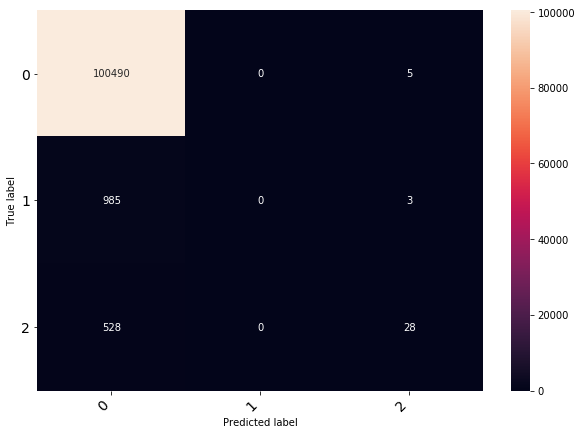

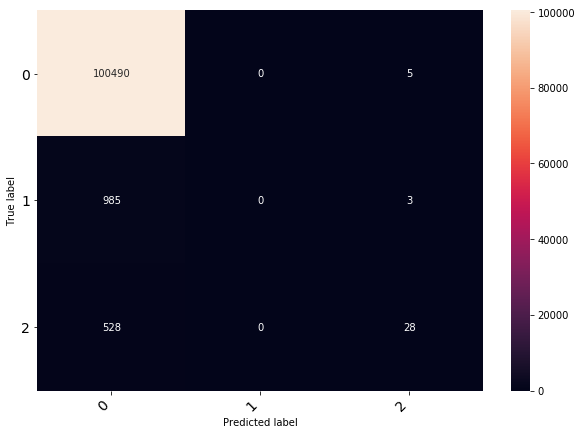

In [107]:
print_confusion_matrix(sklearn.metrics.confusion_matrix(Y_test,ypred),class_names=['0','1','2'])

In [138]:
Y_test[Y_test>0]

array([1, 1, 1, ..., 1, 2, 1])

In [139]:
df.head()

,date,query,tomorrow_net_clicks,bot_clicks_feature,bcfeature1,bcfeature2,bcfeature3,bcfeature4,cfeature4,ifeature4,...,roll_c_feature7_all,roll_c_feature30_all,roll_i_feature2_all,roll_i_feature3_all,roll_i_feature7_all,roll_i_feature30_all,roll_p_feature2_all,roll_p_feature3_all,roll_p_feature7_all,roll_p_feature30_all
0,2019-06-21,?????,0,0,0,0,0,0,0,0,...,85.428571,119.766667,6081.5,5716.333333,5104.857143,6170.533333,37.354981,38.114445,38.424932,33.990731
1,2019-06-21,' mattress store,0,0,0,0,0,0,0,0,...,85.428571,119.766667,6081.5,5716.333333,5104.857143,6170.533333,37.354981,38.114445,38.424932,33.990731
2,2019-06-21,#1 rated mattress,0,0,0,0,0,0,0,0,...,85.428571,119.766667,6081.5,5716.333333,5104.857143,6170.533333,37.354981,38.114445,38.424932,33.990731
3,2019-06-21,10 best mattresses,0,0,0,0,0,0,0,0,...,85.428571,119.766667,6081.5,5716.333333,5104.857143,6170.533333,37.354981,38.114445,38.424932,33.990731
4,2019-06-21,100 cotton percale sheets queen,0,0,0,0,0,0,0,0,...,85.428571,119.766667,6081.5,5716.333333,5104.857143,6170.533333,37.354981,38.114445,38.424932,33.990731
